<a href="https://colab.research.google.com/github/AdeelH/machine_translation/blob/master/690D_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Init

In [0]:
!nvidia-smi

Thu May  9 22:56:20 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.56       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P8    17W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
import unicodedata
import string
import re
import random
import time
import math
from functools import lru_cache

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F
import spacy
import numpy as np


# Data fetching and loading


Fetch from Google Drive

In [0]:
!pip install -U -q PyDrive

import pickle
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
print('success!')

from google import colab
colab.drive.mount('/content/gdrive')





success!
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# https://drive.google.com/open?id=13bmmEylwiRzZ_-TbqspB3SmFcFu8QX3X
train_en_file = drive.CreateFile({'id': '13bmmEylwiRzZ_-TbqspB3SmFcFu8QX3X'})
train_en_file.GetContentFile(f'./train.en') 

# https://drive.google.com/open?id=11sQBdDUCAA_5idGdG1i8bKbHssvkewkQ
train_de_file = drive.CreateFile({'id': '11sQBdDUCAA_5idGdG1i8bKbHssvkewkQ'})
train_de_file.GetContentFile(f'./train.de') 

# https://drive.google.com/open?id=1iueYCDdcwfvrKjT2Z_Y7KKTI0n_FKvsW
dev_de_file = drive.CreateFile({'id': '1iueYCDdcwfvrKjT2Z_Y7KKTI0n_FKvsW'})
dev_de_file.GetContentFile(f'./dev.de') 

# https://drive.google.com/open?id=1BV_lRV3Ve88MbonusforJIYptX_KFlaB
dev_en_file = drive.CreateFile({'id': '1BV_lRV3Ve88MbonusforJIYptX_KFlaB'})
dev_en_file.GetContentFile(f'./dev.en') 

# # https://drive.google.com/open?id=1sy75H0S7G9MfSUG2EVUL8OI85CqJeUu5
test_de_file = drive.CreateFile({'id': '1sy75H0S7G9MfSUG2EVUL8OI85CqJeUu5'})
test_de_file.GetContentFile(f'./test.de') 

Load data from files:

In [0]:
train_en = open('train.en', encoding="utf8").read().strip().split('\n')
train_de = open('train.de', encoding="utf8").read().strip().split('\n')

dev_en = open('dev.en', encoding="utf8").read().strip().split('\n')
dev_de = open('dev.de', encoding="utf8").read().strip().split('\n')

Define sentence delimiters and padding and unknown tokens.

In [0]:
PAD_ = '<PAD>'
BOS_ = '<BOS>'
EOS_ = '<EOS>'
UNK_ = '<unk>'

PAD_IDX = 0
BOS_IDX = 1
EOS_IDX = 2
UNK_IDX = 3

We use Spacy to tokenize our input sentences, so download the relevant language models.

In [0]:
!spacy download en_core_web_md
!spacy download de

Tokenize:

In [0]:
nlp_en = spacy.load("en_core_web_md")
nlp_de = spacy.load("de")

def tokenize(sentences, tokenizer):
    tokenized = [tokenizer(s.strip().lower()) for s in sentences]
    tokenized = [[BOS_] + [token.text for token in sentence] + [EOS_] for sentence in tokenized]
    return tokenized

train_en_tokenized = tokenize(train_en, nlp_en.tokenizer)
train_de_tokenized = tokenize(train_de, nlp_de.tokenizer)

dev_en_tokenized = tokenize(dev_en, nlp_en.tokenizer)
dev_de_tokenized = tokenize(dev_de, nlp_de.tokenizer)



#### Populate vocabularies:

In [0]:
vocab_en = {PAD_: PAD_IDX, BOS_: BOS_IDX, EOS_: EOS_IDX, UNK_: UNK_IDX}
vocab_counts_en = {PAD_: 0, BOS_: 0, EOS_: 0, UNK_: 0}

i = len(vocab_en)
for sentence in train_en_tokenized:
    for word in sentence:
        if word not in vocab_en:
            vocab_en[word] = i
            vocab_counts_en[word] = 1
            i += 1
        vocab_counts_en[word] += 1
len(vocab_en)

In [0]:
vocab_de = {PAD_: PAD_IDX, BOS_: BOS_IDX, EOS_: EOS_IDX, UNK_: UNK_IDX}
vocab_counts_de = {PAD_: 0, BOS_: 0, EOS_: 0, UNK_: 0}

i = len(vocab_de)
for sentence in train_de_tokenized:
    for word in sentence:
        if word not in vocab_de:
            vocab_de[word] = i
            vocab_counts_de[word] = 1
            i += 1
        vocab_counts_de[word] += 1
len(vocab_de)

Save to file for faster reloading:

In [0]:
# path = F"/content/gdrive/My Drive/690D/vocab_de.pkl" 
# with open(path, "wb") as f:
#     pickle.dump(vocab_de, f)

# path = F"/content/gdrive/My Drive/690D/vocab_counts_de.pkl" 
# with open(path, "wb") as f:
#     pickle.dump(vocab_counts_de, f)

# path = F"/content/gdrive/My Drive/690D/vocab_en.pkl" 
# with open(path, "wb") as f:
#     pickle.dump(vocab_en, f)

# path = F"/content/gdrive/My Drive/690D/vocab_counts_en.pkl" 
# with open(path, "wb") as f:
#     pickle.dump(vocab_counts_en, f)

Load from file:

In [0]:
# path = F"/content/gdrive/My Drive/690D/vocab_de.pkl" 
# with open(path, "rb") as f:
#     vocab_de = pickle.load(f)

# path = F"/content/gdrive/My Drive/690D/vocab_counts_de.pkl" 
# with open(path, "rb") as f:
#     vocab_counts_de = pickle.load(f)

# path = F"/content/gdrive/My Drive/690D/vocab_en.pkl" 
# with open(path, "rb") as f:
#     vocab_en = pickle.load(f)

# path = F"/content/gdrive/My Drive/690D/vocab_counts_en.pkl" 
# with open(path, "rb") as f:
#     vocab_counts_en = pickle.load(f)

#### Populate index to word mappings:

In [0]:
idx_to_word_en = [None] * len(vocab_en)
for k, v in vocab_en.items():
    idx_to_word_en[v] = k
sum(i is None for i in idx_to_word_en)

0

In [0]:
idx_to_word_de = [None] * len(vocab_de)
for k, v in vocab_de.items():
    idx_to_word_de[v] = k
sum(i is None for i in idx_to_word_de)

0

# Preprocessing

Truncate to MAX_LEN and pad:

In [0]:
MAX_LEN = 100

In [0]:

def sentence_to_inds(sentence, vocab, max_len):
    padding = [PAD_IDX] * (max_len - len(sentence))
    return [vocab.get(word, UNK_IDX) for word in sentence[:max_len]] + padding

def sentences_to_inds(sentences, vocab, max_len):
    return torch.LongTensor([sentence_to_inds(s, vocab, max_len) for s in sentences])


train_en_idx = sentences_to_inds(train_en_tokenized, vocab_en, MAX_LEN)
train_de_idx = sentences_to_inds(train_de_tokenized, vocab_de, MAX_LEN)

dev_en_idx = sentences_to_inds(dev_en_tokenized, vocab_en, MAX_LEN)
dev_de_idx = sentences_to_inds(dev_de_tokenized, vocab_de, MAX_LEN)


Save to file:

In [0]:
# path = F"/content/gdrive/My Drive/690D/train_en_idx.pkl" 
# with open(path, "wb") as f:
#     pickle.dump(train_en_idx, f)

# path = F"/content/gdrive/My Drive/690D/train_de_idx.pkl" 
# with open(path, "wb") as f:
#     pickle.dump(train_de_idx, f)

# path = F"/content/gdrive/My Drive/690D/dev_en_idx.pkl" 
# with open(path, "wb") as f:
#     pickle.dump(dev_en_idx, f)

# path = F"/content/gdrive/My Drive/690D/dev_de_idx.pkl" 
# with open(path, "wb") as f:
#     pickle.dump(dev_de_idx, f)

Load from file:

In [0]:
# path = F"/content/gdrive/My Drive/690D/train_en_idx.pkl" 
# with open(path, "rb") as f:
#     train_en_idx = pickle.load(f)

# path = F"/content/gdrive/My Drive/690D/train_de_idx.pkl" 
# with open(path, "rb") as f:
#     train_de_idx = pickle.load(f)

# path = F"/content/gdrive/My Drive/690D/dev_en_idx.pkl" 
# with open(path, "rb") as f:
#     dev_en_idx = pickle.load(f)

# path = F"/content/gdrive/My Drive/690D/dev_de_idx.pkl" 
# with open(path, "rb") as f:
#     dev_de_idx = pickle.load(f)

Calculate sequence lengths. Will be used for making bins later.

In [0]:
train_en_lens = torch.LongTensor([n for n in (train_en_idx != PAD_IDX).sum(dim=1)])
train_de_lens = torch.LongTensor([n for n in (train_de_idx != PAD_IDX).sum(dim=1)])

dev_de_lens = torch.LongTensor([n for n in (dev_de_idx != PAD_IDX).sum(dim=1)])
dev_en_lens = torch.LongTensor([n for n in (dev_en_idx != PAD_IDX).sum(dim=1)])

# GloVE embeddings

Data loading adapted from: https://medium.com/@martinpella/how-to-use-pre-trained-word-embeddings-in-pytorch-71ca59249f76

In [0]:
!pip install bcolz

glove_dim = 300

## Load EN

In [0]:
import bcolz

# https://drive.google.com/open?id=1YS8b5YGz462bTQ2PbJ0zjUkc29d2iwJb
en_emb_vecs = drive.CreateFile({'id': '1YS8b5YGz462bTQ2PbJ0zjUkc29d2iwJb'})


words = []
idx = 0
word2idx = {}
glove_path = '.'
cparams = bcolz.cparams(clevel=6)

en_emb_vecs.GetContentFile(f'{glove_path}/glove.6B.{glove_dim}d.txt') 
vectors = bcolz.carray(np.zeros(1), rootdir=f'{glove_path}/6B.{glove_dim}.dat', mode='w', cparams=cparams)

with open(f'{glove_path}/glove.6B.{glove_dim}d.txt', 'rb') as f:
    for l in f:
        line = l.decode().split()
        word = line[0]
        words.append(word)
        word2idx[word] = idx
        idx += 1
        vect = np.array(line[1:]).astype(np.float)
        vectors.append(vect)

vectors = bcolz.carray(vectors[1:].reshape((-1, glove_dim)), rootdir=f'{glove_path}/6B.{glove_dim}.dat', mode='w', cparams=cparams)
vectors.flush()


In [0]:
glove = {w: vectors[word2idx[w]] for w in words}

## Load DE

In [0]:
import bcolz

# https://drive.google.com/open?id=17zgrEtVQ-wbks4mqGDyVAqut7sUAXVYa

de_emb_vecs = drive.CreateFile({'id': '17zgrEtVQ-wbks4mqGDyVAqut7sUAXVYa'})
de_emb_vecs.GetContentFile('./de_embs.txt') 

words_de = []
idx = 0
word2idx_de = {}
glove_path_de = '.'
glove_dim = 300
dat_file = f'{glove_path_de}/de.{glove_dim}.dat'
cparams = bcolz.cparams(clevel=9, cname="zlib")

!rm -rf "de.300.dat"

vectors_de = bcolz.carray(np.zeros(1), rootdir=dat_file, mode='w', cparams=cparams)

with open('./de_embs.txt', 'rb') as f:
    for l in f:
        line = l.decode().split()
        word = line[0]
        words_de.append(word)
        word2idx_de[word] = idx
        idx += 1
        vect = np.array(line[1:]).astype(np.float)
        vectors_de.append(vect)
        
vectors_de = bcolz.carray(vectors_de[1:].reshape((-1, glove_dim)), rootdir=dat_file, mode='w', cparams=cparams)
vectors_de.flush()


In [0]:
glove_de = {w: vectors_de[word2idx_de[w]] for w in words_de}

Save to file:

In [0]:
# path = F"/content/gdrive/My Drive/690D/glove.pkl" 
# with open(path, "wb") as f:
#     pickle.dump(glove, f)

# path = F"/content/gdrive/My Drive/690D/glove_de.pkl" 
# with open(path, "wb") as f:
#     pickle.dump(glove_de, f)

Load from file:

In [0]:
# path = F"/content/gdrive/My Drive/690D/glove.pkl" 
# with open(path, "rb") as f:
#     glove = pickle.load(f)

# path = F"/content/gdrive/My Drive/690D/glove_de.pkl" 
# with open(path, "rb") as f:
#     glove_de = pickle.load(f)

## Prep embeddings

In [0]:

def create_glove_embeddings(target_vocab, word2vec, emb_dim):
    matrix_len = len(target_vocab)
    weights_matrix = np.zeros((matrix_len, emb_dim))
    words_found = 0

    for word, idx in target_vocab.items():
        try: 
            weights_matrix[idx] = word2vec[word]
            words_found += 1
        except KeyError:
            weights_matrix[idx] = np.random.normal(scale=0.6, size=(emb_dim, ))
    print(f'{words_found} words found')
    return weights_matrix

glove_embeddings = create_glove_embeddings(vocab_en, glove, glove_dim)
glove_embeddings_de = create_glove_embeddings(vocab_de, glove_de, glove_dim)

Save:

In [0]:
# path = F"/content/gdrive/My Drive/690D/glove_embeddings.pkl" 
# with open(path, "wb") as f:
#     pickle.dump(glove_embeddings, f)

# path = F"/content/gdrive/My Drive/690D/glove_embeddings_de.pkl" 
# with open(path, "wb") as f:
#     pickle.dump(glove_embeddings_de, f)

Load:

In [0]:
# path = F"/content/gdrive/My Drive/690D/glove_embeddings.pkl" 
# with open(path, "rb") as f:
#     glove_embeddings = pickle.load(f)

# path = F"/content/gdrive/My Drive/690D/glove_embeddings_de.pkl" 
# with open(path, "rb") as f:
#     glove_embeddings_de = pickle.load(f)
    


# Character Embeddings

## Preprocessing

In [0]:
de_chars = [torch.FloatTensor([ord(c) for c in w]) for w in vocab_de.keys()]
en_chars = [torch.FloatTensor([ord(c) for c in w]) for w in vocab_en.keys()]

In [0]:
print(max(len(cs) for cs in de_chars))
print(sum(len(cs) for cs in de_chars) / len(de_chars))

print(max(len(cs) for cs in en_chars))
print(sum(len(cs) for cs in en_chars) / len(de_chars))

In [0]:
de_chars.append(torch.zeros((100,)))
de_chars_train = nn.utils.rnn.pad_sequence(de_chars, batch_first=True, padding_value=-1)
de_chars_train = de_chars_train[:-1, :]
print(de_chars_train = de_chars_train[:-1, :])

en_chars.append(torch.zeros((100,)))
en_chars_train = nn.utils.rnn.pad_sequence(en_chars, batch_first=True, padding_value=-1)
en_chars_train = en_chars_train[:-1, :]
print(en_chars_train.shape)

## The AutoEncoder

In [0]:

class CharCoder(nn.Module):
    def __init__(self, d_in):
        super(CharCoder, self).__init__()
        
        self.enc = nn.Sequential(
            nn.Linear(d_in, 1024),
            nn.LeakyReLU(0.1),
            nn.BatchNorm1d(1024),
            nn.Linear(1024, 256),
            nn.LeakyReLU(0.1),
            nn.BatchNorm1d(256),
            nn.Linear(256, 64)
        )
        self.dec = nn.Sequential(
            nn.Linear(64, 256),
            nn.LeakyReLU(0.1),
            nn.BatchNorm1d(256),
            nn.Linear(256, 1024),
            nn.LeakyReLU(0.1),
            nn.BatchNorm1d(1024),
            nn.Linear(1024, d_in)
        )

    def forward(self, X):
        out = self.dec(self.enc(X))
        return out

## Training loop

In [0]:

def train_cc(X, model, params, optimizer, print_every=10):

    criterion = nn.MSELoss().cuda()
    
    N = X.shape[0]
    
    b_sz = params['batch_size']
    batches = [(start, start + b_sz) for start in range(0, N, b_sz)]
    
    model.train()
    for epoch in range(params['epochs']):
        ep_loss = 0.
        start_time = time.time()
        random.shuffle(batches)

        # for each batch, calculate loss and optimize model parameters
        for b_idx, (start, end) in enumerate(batches):
            x = X[start:end].cuda()
            mask = x >= 0
            
            preds = model(x)

            loss = criterion(preds[mask], x[mask])

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            ep_loss += loss.detach().cpu()
        
        if (epoch + 1) % print_every == 0:
            print('epoch: %d, loss: %0.4f, time: %0.2f sec' % \
                  (epoch, ep_loss, time.time() - start_time))
        


## Train DE

In [0]:
torch.cuda.empty_cache()
cc_de = CharCoder(100).cuda()

In [0]:
cparams = {}
cparams['batch_size'] = 8192*4
cparams['epochs'] = 200

coptimizer_de = optim.Adam(cc_de.parameters(), lr=0.000001)

torch.cuda.empty_cache()
train_cc(de_chars_train, cc_de, cparams, coptimizer_de)

## Train EN

In [0]:
torch.cuda.empty_cache()
cc_en = CharCoder(100).cuda()

In [0]:
cparams = {}
cparams['batch_size'] = 8192*4
cparams['epochs'] = 200

coptimizer_en = optim.Adam(cc_en.parameters(), lr=0.00001)

torch.cuda.empty_cache()
train_cc(en_chars_train, cc_en, cparams, coptimizer_en)

Save:

In [0]:
# from google.colab import drive
# import pickle
# drive.mount('/content/gdrive')

# model_save_name = 'cc_en.pt'
# path = F"/content/gdrive/My Drive/690D/{model_save_name}" 
# torch.save(cc_en.state_dict(), path)


# model_save_name = 'cc_de.pt'
# path = F"/content/gdrive/My Drive/690D/{model_save_name}" 
# torch.save(cc_de.state_dict(), path)
    


In [0]:
# model_save_name = 'cc_en.pt'
# path = F"/content/gdrive/My Drive/690D/{model_save_name}" 
# cc_en.load_state_dict(torch.load(path))

# model_save_name = 'cc_de.pt'
# path = F"/content/gdrive/My Drive/690D/{model_save_name}" 
# cc_de.load_state_dict(torch.load(path))

Create embeddings for all token in vocab:

In [0]:
def create_char_embeddings(target_vocab, chars, cc_model):
    
    char_embs_ = cc_model.enc(chars.cuda()).detach().cpu()
    emb_dim = char_embs_.shape[1]
    
    matrix_len = len(target_vocab)
    weights_matrix = np.zeros((matrix_len, emb_dim))

    for word, idx in target_vocab.items():
        weights_matrix[idx] = char_embs_[idx]

    return weights_matrix

char_embs_en = create_char_embeddings(vocab_en, en_chars_train, cc_en)
char_embs_de = create_char_embeddings(vocab_de, de_chars_train, cc_de)


Load:

In [0]:
# from google.colab import drive
# import pickle
# drive.mount('/content/gdrive')

# path = F"/content/gdrive/My Drive/690D/char_embs_en.pkl" 
# with open(path, "wb") as f:
#     pickle.dump(char_embs_en, f)

# path = F"/content/gdrive/My Drive/690D/char_embs_de.pkl" 
# with open(path, "wb") as f:
#     pickle.dump(char_embs_de, f)

path = F"/content/gdrive/My Drive/690D/char_embs_en.pkl"
with open(path, "rb") as f:
    char_embs_en = pickle.load(f)

path = F"/content/gdrive/My Drive/690D/char_embs_de.pkl"
with open(path, "rb") as f:
    char_embs_de = pickle.load(f)

print(char_embs_en.shape)
print(char_embs_de.shape)

## Concatenate with GloVE embeddings

In [0]:
glove_embeddings = np.concatenate((char_embs_en, glove_embeddings), axis=1)
glove_embeddings_de = np.concatenate((char_embs_de, glove_embeddings_de), axis=1)

print(glove_embeddings.shape)
print(glove_embeddings_de.shape)

---------------------------------------------

# Transformer

A cleaner, though probably less efficient, implementation than others I have seen.

#### Attention

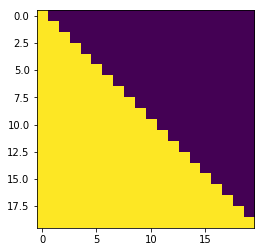

In [0]:
import matplotlib.pyplot as plt

@lru_cache(maxsize=16)
def get_mask(seq_len):
    return (torch.ones((seq_len, seq_len)).tril() == 1).cuda() # valid positions


plt.imshow(get_mask(20).cpu())

In [0]:
   
class AttentionCell(nn.Module):
    def __init__(self, d_in, d_k, d_z):
        super(AttentionCell, self).__init__()
        
        self.Wq = nn.Linear(d_in, d_k)
        self.Wk = nn.Linear(d_in, d_k)
        self.Wv = nn.Linear(d_in, d_z)
        self.scaling = d_k**(-0.5)
        
    def forward(self, Q, K, V, mask):
        
        q = self.Wq(Q)
        k = self.Wk(K)
        v = self.Wv(V)
        
        
        # (N, seq_len, d_k) x (N, d_k, seq_len) -> (N, seq_len, seq_len)
        scores = torch.bmm(q, k.transpose(1, 2)) * self.scaling
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e10)
        scores = F.softmax(scores, dim=-1)
        
        z = torch.bmm(scores, v)

        return z



#### Multi-head attention

In [0]:
class MultiHeadAttentionCell(nn.Module):
    def __init__(self, nheads, d_in, d_k, d_z, p_dropout=0.1):
        super(MultiHeadAttentionCell, self).__init__()

        self.heads = nn.ModuleList(
            [AttentionCell(d_in, d_k, d_z) for _ in range(nheads)]
        )
        self.Wo = nn.Sequential(
            nn.Linear(d_z * nheads, d_in),
            nn.Dropout(p_dropout)
        )
        
        
    def forward(self, Q, K, V, mask=None):
        
        zs = torch.cat([head(Q, K, V, mask) for head in self.heads], dim=2)
        z = self.Wo(zs)
        
        return z



#### Encoder

In [0]:
class EncoderCell(nn.Module):
    def __init__(self, params):
        super(EncoderCell, self).__init__()
        
        d_in, d_k, d_z = params['d_in'], params['d_k'], params['d_z']
        d_out = params['d_out']
        nheads = params['nheads']
        dropout_attn = params['dropout_attn']
        d_h = params['d_h']
        
        self.SelfAttentionBlock = MultiHeadAttentionCell(nheads, d_in, d_k, d_z, dropout_attn)
        self.norm1 = nn.LayerNorm(d_in)
        
        self.We = nn.Sequential(
            nn.Linear(d_in, d_h),
            nn.ReLU(),
            nn.Dropout(params['dropout_ff']),
            nn.Linear(d_h, d_out)
        )
        self.norm2 = nn.LayerNorm(d_in)
        
        
    def forward(self, inp):
        X, src_mask = inp
        z = self.SelfAttentionBlock(X, X, X, src_mask)
        norm1 = self.norm1(X + z)
        e = self.We(norm1)
        norm2 = self.norm2(z + e)
        
        return norm2, src_mask

#### Decoder

In [0]:

class DecoderCell(nn.Module):
    def __init__(self, params):
        super(DecoderCell, self).__init__()
        
        d_in, d_k, d_z = params['d_in'], params['d_k'], params['d_z']
        d_out = params['d_out']
        nheads_attn, nheads_self_attn = params['nheads_attn'], params['nheads_self_attn']
        dropout_attn, dropout_self_attn = params['dropout_attn'], params['dropout_self_attn']
        d_h = params['d_h']
        
        self.SelfAttentionBlock = MultiHeadAttentionCell(nheads_self_attn, d_in, d_k, d_z, dropout_self_attn)
        self.EncDecAttentionBlock = MultiHeadAttentionCell(nheads_attn, d_in, d_k, d_z, dropout_attn)

        self.norm1 = nn.LayerNorm(d_in)
        self.norm2 = nn.LayerNorm(d_in)
        self.norm3 = nn.LayerNorm(d_in)
        
        self.Wd = nn.Sequential(
            nn.Linear(d_in, d_h),
            nn.ReLU(),
            nn.Dropout(params['dropout_ff']),
            nn.Linear(d_h, d_out)
        )


    def forward(self, inp):
        
        X, enc_out, src_mask, tgt_mask = inp
        self_attn_out = self.SelfAttentionBlock(X, X, X, mask=tgt_mask)
        norm1 = self.norm1(X + self_attn_out)
        
        encdec_attn_out = self.EncDecAttentionBlock(norm1, enc_out, enc_out, mask=src_mask)
        norm2 = self.norm2(norm1 + encdec_attn_out)
        
        ff_out = self.Wd(norm2)
        norm3 = self.norm2(norm2 + ff_out)
        out = norm3
        
        return (out, enc_out, src_mask, tgt_mask)

#### Positional embeddings

In [0]:


@lru_cache(maxsize=128)
def get_positional_embeddings(seq_len, d_emb):

    js = (torch.arange(d_emb).float() // 2) * 2
    denom = (10000**(js / d_emb)).reshape(1, -1)

    i = torch.arange(seq_len).reshape(-1, 1).repeat((1, d_emb)).float()

    pos_embed = i / denom

    is_even_ind = np.arange(d_emb) % 2 == 0
    even_inds = np.where(is_even_ind)
    odd_inds = np.where(1 - is_even_ind)

    pos_embed[:, even_inds] = np.sin(pos_embed[:, even_inds])
    pos_embed[:, odd_inds] = np.cos(pos_embed[:, odd_inds])
    
    return pos_embed.cuda()


#### Transformer

In [0]:

class Transformer(nn.Module):
    def __init__(self, params, embeddings_in=None, embeddings_out=None):
        super(Transformer, self).__init__()
        
        in_vocab_size, out_vocab_size = params['in_vocab_size'], params['out_vocab_size']
        d_emb_in, d_emb_out = params['d_emb_in'], params['d_emb_out']
        self.embeddings_in = nn.Embedding(in_vocab_size, d_emb_in)
        self.embeddings_out = nn.Embedding(out_vocab_size, d_emb_out)
        
        if embeddings_in is not None:
            self.embeddings_in.weight.data = torch.from_numpy(embeddings_in).float().cuda()
            self.embeddings_in.weight.requires_grad = False
        if embeddings_out is not None:
            self.embeddings_out.weight.data = torch.from_numpy(embeddings_out).float().cuda()
            self.embeddings_out.weight.requires_grad = False
        
        nencoders = params['nencoders']
        ndecoders = params['ndecoders']
        
        self.encoder = nn.Sequential(
            *[EncoderCell(params['encoder']) for _ in range(nencoders)]
        )
        self.decoder = nn.Sequential(
            *[DecoderCell(params['decoder']) for _ in range(ndecoders)]
        )
        
        self.Wt = nn.Linear(params['decoder']['d_out'], out_vocab_size)
        
        
    def forward(self, X, Y, src_mask=None, tgt_mask=None):
        
        encoding = self.encode_(X, src_mask=src_mask)
        decoding = self.decode_(Y, encoding, src_mask=src_mask, tgt_mask=tgt_mask)
        logits = self.Wt(decoding)
        
        return logits
    
    def encode_(self, X, src_mask=None):
        embs_in = self.embeddings_in(X)
        embs_in += get_positional_embeddings(embs_in.shape[1], embs_in.shape[2])
        encoding, _ = self.encoder((embs_in, src_mask))
        return encoding
    
    def decode_(self, Y, encoding, src_mask=None, tgt_mask=None):
        embs_out = self.embeddings_out(Y)
        embs_out += get_positional_embeddings(embs_out.shape[1], embs_out.shape[2])
        decoding, _, _, _ = self.decoder((embs_out, encoding, src_mask, tgt_mask))
        return decoding

    
        

# Make Model

d_in should be set to 364 if using GloVE + Character embeddings.

In [0]:
model = None
torch.cuda.empty_cache()

in_vocab  = vocab_de
out_vocab = vocab_en

# model
# seq_len = train_X.shape[1]
d_in = 300
# d_in = 364
d_k = 64
d_z = d_k * 2
d_h = d_in * 1

## model
model_params = {}
model_params['in_vocab_size'] = len(in_vocab)
model_params['out_vocab_size'] = len(out_vocab)
model_params['d_emb_in'] = d_in
model_params['d_emb_out'] = d_in
model_params['nencoders'] = 2
model_params['ndecoders'] = 2
# encoder params
model_params['encoder'] = {}
model_params['encoder']['nheads'] = 4
model_params['encoder']['d_in'] = d_in
model_params['encoder']['d_k']  = d_k
model_params['encoder']['d_z']  = d_z
model_params['encoder']['d_h']  = d_h
model_params['encoder']['d_out'] = d_in
model_params['encoder']['dropout_ff'] = 0.1
model_params['encoder']['dropout_attn']  = 0.1
# decoder params
model_params['decoder'] = {}
model_params['decoder']['nheads_attn'] = 4
model_params['decoder']['nheads_self_attn'] = 4
model_params['decoder']['d_in'] = d_in
model_params['decoder']['d_k']  = d_k
model_params['decoder']['d_z']  = d_z
model_params['decoder']['d_h']  = d_h
model_params['decoder']['d_out'] = d_in
model_params['decoder']['dropout_ff'] = 0.1
model_params['decoder']['dropout_attn']  = 0.1
model_params['decoder']['dropout_self_attn']  = 0.1

model = None
# model = Transformer(model_params).cuda()
model = Transformer(model_params, embeddings_in=glove_embeddings_de, embeddings_out=glove_embeddings).cuda()
torch.cuda.empty_cache()

In [0]:
# nick = '4,4,4,4,r'
# model_save_name = f'transformer{nick}.pt'
# path = F"/content/gdrive/My Drive/690D/{model_save_name}" 
# model.load_state_dict(torch.load(path))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

# Translate

Define Greedy decoding and Beam Search decoding functions.

## Greedy decoding

In [0]:
def decode_helper_greedy(model, out, encoding, src_mask, tgt_mask):
    
    out[:, 0] = BOS_IDX

    for i in range(1, out.shape[1]):
        decoding = model.decode_(out, encoding, src_mask, tgt_mask).detach()
        logits = model.Wt(decoding[:, i]).detach()
        scores = F.softmax(logits, dim=-1).detach()
        sampled_word = torch.argmax(scores, dim=-1)
        out[:, i] = sampled_word

    return out

## Beam search

In [0]:
def decode_helper_beam_search(model, out, encoding, src_mask, tgt_mask, k=4, debug=False):
    
    beam_p = torch.ones((out.shape[0], k))
    beam_idx = torch.zeros((out.shape[0], out.shape[1], k)) + BOS_IDX
    
    tmp_p = torch.zeros((out.shape[0], k*k))
    tmp_idx = torch.zeros((out.shape[0], k*k))
    
    not_ended = [True] * k
    for i in range(1, out.shape[1] - 1):
        if sum(not_ended) == 0:
            break
        for j in range(k):
            
            out[:, : i] = beam_idx[:, : i, j]
            ended = (out[:, : i] == EOS_IDX).sum(dim=1) > 0
            
            if (1 - ended).sum() == 0:
                not_ended[j] = False
                continue
            
            decoding = model.decode_(out, encoding, src_mask, tgt_mask).detach()
            logits = model.Wt(decoding[:, i - 1]).detach()
            scores = F.softmax(logits, dim=-1).detach()
            
            p, idx = torch.topk(scores.cpu(), k, largest=True, dim=-1)
            p[ended, -1] = 1
            p[ended, :-1] = 0
            idx[ended, -1] = PAD_IDX
            tmp_p[:, j : j + k] = beam_p[:, j].unsqueeze(-1) * p
            tmp_idx[:, j : j + k] = idx
            
            if i == 1:
                break
        tmp_p, sort_idx = torch.sort(tmp_p, dim=1, descending=True)
        tmp_idx = torch.gather(tmp_idx, 1, sort_idx)
        beam_p = tmp_p[:, : k]
        beam_idx[:, i, :] = tmp_idx[:, : k]
        
        if debug:
            for m in range(k):
                for r, row in enumerate(beam_idx[:, : i + 1, m]):
                    row = takewhile(lambda i: i != EOS_IDX, row)
                    print(beam_p[r, m], ' '.join(idx_to_word_en[int(w)] for w in row))
            print()
        
    
    return beam_idx[:, :, 0].cpu().long()

In [0]:
from itertools import takewhile


def inds_to_sentences(sentence_inds, idx_to_word):
    truncated = [takewhile(lambda i: i != EOS_IDX, s[1:]) for s in sentence_inds]
    return [' '. join(idx_to_word[idx] for idx in s) for s in truncated]


def decode(model, X, max_len, greedy=False):
    src_mask = (X != PAD_IDX).unsqueeze(-2)
    tgt_mask = get_mask(max_len)
    encoding = model.encode_(X, src_mask)
    out = torch.zeros((X.shape[0], max_len)).long().cuda() + PAD_IDX
    if greedy:
        decoding = decode_helper_greedy(model, out, encoding, src_mask, tgt_mask)
    else:
        decoding = decode_helper_beam_search(model, out, encoding, src_mask, tgt_mask)
    return decoding


def translate(model, in_sentences, in_tokenizer, in_vocab, out_idx_to_word, max_len, greedy=False):
    
    tokenized = [in_tokenizer(s.strip().lower()) for s in in_sentences]
    tokenized = [[BOS_] + [token.text for token in sentence] + [EOS_] for sentence in tokenized]
    
    X = sentences_to_inds(tokenized, in_vocab, max_len).cuda()
    model.eval()
    model_out = decode(model, X, max_len)
    translation = inds_to_sentences(model_out, out_idx_to_word)
    return translation



## Test translation

In [0]:
sentences = []
sentences.append('das ist sehr gut')
sentences.append('brot und wasser')
sentences.append('ich bin einen apfel')
sentences.append('Wir müssen wissen - wir werden wissen!')
print(sentences)

# translate
model.eval()
translation = translate(model, sentences, nlp_de.tokenizer, vocab_de, idx_to_word_en, max_len=MAX_LEN, greedy=False)
for s in translation:
    print(s)
print()

# Train

## The training loop

In [0]:

def train_transformer(train_seq_bins, dev_seq_bins, model, params, optimizer, max_epoch_iters=100):

    target_vocab_sz = params['out_vocab_size']
    
    criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX).cuda()
    
    model.train()
    for epoch in range(params['epochs']):
        ep_loss1 = 0.
        ep_loss2 = 0.
        ep_start_time = time.time()

        for i, (X, Y, bsz) in enumerate(train_seq_bins):
            N = X.shape[0]
            batches = [(start, start + bsz) for start in range(0, N, bsz)]
            random.shuffle(batches)
            b_loss1 = 0.
            b_loss2 = 0.
            b_start_time = time.time()
            
            for b_idx, (start, end) in enumerate(batches):

                x = X[start:end].contiguous().cuda()
                y = Y[start:end].contiguous().cuda()
                
                src_mask = (x != PAD_IDX).unsqueeze(-2)
                y_nonpad = (y != PAD_IDX)
                tgt_mask = y_nonpad.unsqueeze(-2) & get_mask(y.shape[1])
                
                preds = model(x, y, src_mask=src_mask, tgt_mask=tgt_mask)
                preds = preds[:, :-1, :].contiguous().view(-1, target_vocab_sz)
                labels = y[:, 1:].contiguous().view(-1)
                
                loss1 = criterion(preds, labels)

                loss = loss1

                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                b_loss1 += loss1.detach().cpu()
        
            print('bin: %d, loss: %0.4f, loss_emb: %0.4f, time: %0.2f sec' % \
                  (i, b_loss1, b_loss2, time.time() - b_start_time))
        
            ep_loss1 += b_loss1.detach().cpu()
#             ep_loss2 += b_loss2.detach().cpu()
        print('>> epoch: %d, loss: %0.4f, loss_emb: %0.4f, time: %0.2f sec' % \
              (epoch, ep_loss1, ep_loss2, time.time() - ep_start_time))
        
        if (epoch + 1) % 2 == 0:
            model.eval()
            dev_loss = 0.
            for i, (X, Y, bsz) in enumerate(dev_seq_bins):
                N = X.shape[0]
                batches = [(start, start + bsz) for start in range(0, N, bsz)]
                dev_start_time = time.time()

                for b_idx, (start, end) in enumerate(batches):

                    x = X[start:end].contiguous().cuda()
                    y = Y[start:end].contiguous().cuda()

                    src_mask = (x != PAD_IDX).unsqueeze(-2)
                    tgt_mask = (y != PAD_IDX).unsqueeze(-2) & get_mask(y.shape[1])

                    preds = model(x, y, src_mask=src_mask, tgt_mask=tgt_mask)
                    preds = preds[:, :-1, :].contiguous().view(-1, target_vocab_sz)
                    labels = y[:, 1:].contiguous().view(-1)

                    dev_loss += criterion(preds, labels).detach().cpu()
            print('>>>> val: loss: %0.4f, loss_emb: %0.4f, time: %0.2f sec' % \
              (dev_loss, 0, time.time() - dev_start_time))
            
            print()
            translation = translate(model, sentences, nlp_de.tokenizer, vocab_de, idx_to_word_en, MAX_LEN)
            for s in translation:
                print(s)
            print()
            model.train()



## Make bins

In [0]:
len_bins = [8, 12, 16, 20, 24, 32, 40, 64, 100]

last = 0
for i in len_bins:
    n = ((last < train_de_lens) & (train_de_lens <= i)).sum()
#     print(i, n, n - last)
    last = i
    
last = 0
for i in len_bins:
    n = (dev_de_lens <= i).sum()
#     print(i, n, n - last)
    last = i

In [0]:
bin_batch_sizes = (np.array([768, 512, 400, 320, 256, 200, 160, 100, 50]) / 1.).astype(int)
# bin_batch_sizes = np.array([700, 400, 320, 256, 200, 160, 100, 64, 32]) // 2

assert len(bin_batch_sizes) == len(len_bins)


def make_seq_bins(X, X_lens, Y, Y_lens, len_bins, bin_batch_sizes, margin=4):
    
    seq_bins = []
    
    last_i = 0
    for i, bsz in zip(len_bins, bin_batch_sizes):
        mask = ((last_i < X_lens) & (X_lens <= i))
        xs, ys = X[mask], Y[mask]
        y_lens = Y_lens[mask]

        is_long = y_lens > i + margin
        is_short =  1 - is_long

        short_xs, short_ys = xs[is_short, : i], ys[is_short, : i + margin]
        max_y_len = y_lens.max()
        long_xs, long_ys = xs[is_long, : i], ys[is_long, : max_y_len]

        if is_long.sum() == 0:
            break

        long_bsz = bsz // 4
        
#         print(i, (is_short).sum(), bsz)
#         print(i, (is_long).sum(), long_bsz)

        seq_bins.append((short_xs, short_ys, bsz))
        seq_bins.append((long_xs, long_ys, long_bsz))
        
        last_i = i
    return seq_bins

# print('Train')
train_seq_bins = make_seq_bins(train_de_idx, train_de_lens, train_en_idx, train_en_lens, len_bins, bin_batch_sizes)
# print('Dev')
dev_seq_bins = make_seq_bins(dev_de_idx, dev_de_lens, dev_en_idx, dev_en_lens, len_bins, bin_batch_sizes)

## Train!

In [0]:
# print(sentences)
## training
train_params = {}
train_params['out_vocab_size'] = model_params['out_vocab_size']
train_params['learning_rate'] = 1e-4
# train_params['batch_size'] = 128
train_params['epochs'] = 4

# optimizer = None
optimizer = optim.Adam(model.parameters(), lr=train_params['learning_rate'], weight_decay=0)

print(train_params)
print()

model.train()
torch.cuda.empty_cache()
train_transformer(train_seq_bins, dev_seq_bins, model, train_params, optimizer)

In [0]:
torch.cuda.empty_cache()

Save model to file. Super important.

In [0]:
# from google.colab import drive
# import pickle
# drive.mount('/content/gdrive')

# nick = '4,4,4,4,cc2'

# model_save_name = f'transformer{nick}.pt'
# path = F"/content/gdrive/My Drive/690D/{model_save_name}" 
# torch.save(model.state_dict(), path)


# model_params_save_name = f'params{nick}.pt'
# path = F"/content/gdrive/My Drive/690D/{model_params_save_name}" 
# with open(path, "wb") as f:
#     pickle.dump(model_params, f)
    


# BLEU

## Fetch data

In [0]:
!git clone https://github.com/moses-smt/mosesdecoder.git
!pip install sacrebleu
# # !pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
print('Authentication Successful!')
iwslt_data = drive.CreateFile({'id': '1Swpb8yG3atDzxiOR0dQuFE-3KjgZCuWE'})
iwslt_data.GetContentFile('iwslt_en_de.zip')

!unzip iwslt_en_de.zip dev.en

## Load data

In [0]:
dev_de = open('dev.de', encoding="utf8").read().strip().split('\n')
print(dev_de[:2])

['Als ich in meinen 20ern war, hatte ich meine erste Psychotherapie-Patientin.', 'Ich war Doktorandin und studierte Klinische Psychologie in Berkeley.']


In [0]:
test_de = open('test.de', encoding="utf8").read().strip().split('\n')
print(test_de[:2])

['Mein Ziel in diesem Video und dem nächsten ist es,  ', 'einen Eindruck von der Größe der Erde (wirklich nur der Erde)  ']


## Translate and write to file

In [0]:
# !rm "dev.out.en"

out_file = 'dev.out.en'
# out_file = 'test.en'
in_sentences = dev_de
# in_sentences = test_de


bsz = 120
model.eval()
with open(out_file, 'w') as f:
    for i in range(0, len(in_sentences), bsz):
        tr_start_time = time.time()
        translation = translate(model, in_sentences[i : i + bsz], nlp_de.tokenizer, vocab_de, idx_to_word_en, MAX_LEN, greedy=False)
        print(i, time.time() - tr_start_time, translation[0])
        for line in translation:
            f.write(line + '\n')


## Calculate BLEU scores

In [0]:
%%shell
#!/bin/bash

rm "dev.out.en.detok"

# This is a reference to the gold translations from the dev set
REFERENCE_FILE="dev.en"

# XXX: Change the following line to point to your model's output!
TRANSLATED_FILE="dev.out.en"

# The model output is expected to be in a tokenized form. Note, that if you
# tokenized your inputs to the model, then simply joined each output token with
# whitespace you should get tokenized outputs from your model.
# i.e. each output token is separate by whitespace
# e.g. "My model 's output is interesting ."
perl "mosesdecoder/scripts/tokenizer/detokenizer.perl" -l en < "$TRANSLATED_FILE" > "$TRANSLATED_FILE.detok"

PARAMS=("-tok" "intl" "-l" "de-en" "$REFERENCE_FILE")
sacrebleu "${PARAMS[@]}" < "$TRANSLATED_FILE.detok"